In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_config,
                                         set_config)

from hybrids import HybridSVD, HybridSVDColdStart
from data_preprocessing import (get_yahoo_music_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generationa
max_test_workers = 6 # use this manyparallel thread for evaluation each using up to {memory_hard_limit} Gb of RAM

In [3]:
seed = 42

In [4]:
experiment_name = 'hybridsvd'

# Experiment setup

In [5]:
data_labels = ['YaMus']

In [6]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'YaMus': ranks_grid}

hybridsvd_weights = [0.1, 0.3, 0.5, 0.7, 0.9]

In [7]:
topk_values = [1, 3, 10, 20, 30]

In [8]:
target_metric = 'mrr'

In [9]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [10]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Yahoo Music

In [11]:
lbl = 'YaMus'

In [12]:
data_dict[lbl], meta_dict[lbl] = get_yahoo_music_data('../datasets/yahoo_music/yamus_train0_rating5.gz',
                                                      meta_path='../datasets/yahoo_music/yamus_attrs.gz',
                                                      implicit=True,
                                                      pcore=5,
                                                      filter_data={'genreid': [0]}, # filter unknown genre
                                                      filter_no_meta=True)

In [13]:
meta_dict[lbl].head()

,albumid,artistid,genreid
songid,,,
0,[12070],[8490],[]
1,[19512],[7975],[134]
2,[18953],[3492],[]
3,[695],[2653],[]
4,[243],[2282],[]


In [14]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [15]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [16]:
print_data_stats(data_labels, all_data)

YaMus
{'userid': 183003, 'songid': 134059}
density 0.09740952587383789
similarity matrix density 0.4576464914574314


# Standard experiment

In [17]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = HybridSVD(data_model)
    svd.max_test_workers = max_test_workers
    models = [svd]
    apply_config(models, config, data_label)
    return models


def fine_tune_hybridsvd(model, ranks, weights, label, record_time=False):
    param_grid = [(w, r) for w in weights for r in reversed(list(sorted(ranks)))]
    param_names = ('features_weight', 'rank')
    model.max_test_workers = max_test_workers
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores

## tuning

In [18]:
config = {}
scores = {}
data_models = {}

In [19]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_hybridsvd(HybridSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       hybridsvd_weights,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 1/1 [20:14:37<20:14:37, 72876.77s/it]

          YaMus [█████████████████████████████████████████████] 130/130 [20:14:07<00:51, 560.36s/it]

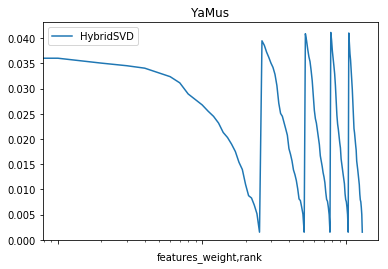

In [20]:
report_results('rank', scores);

In [21]:
config

{'YaMus': {'HybridSVD': {'features_weight': 0.7, 'rank': 3000}}}

### saving data

In [22]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [23]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 1/1 [16:06:29<16:06:29, 57989.24s/it]

          YaMus [█████████████████████████████████████████████] 5/5 [16:06:29<04:18:04, 11597.84s/it]

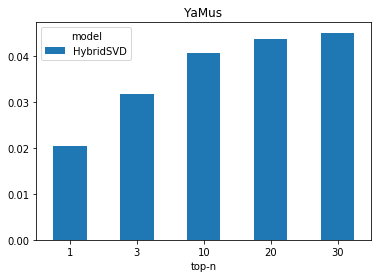

In [24]:
report_results('topn', result, target_metric);

### saving data

In [25]:
save_results(experiment_name, cv=result)

# Cold start

In [31]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = HybridSVDColdStart(data_model, item_features=meta_dict[data_label])
    svd.max_test_workers = max_test_workers
    models = [svd]
    apply_config(models, config, data_label)
    return models

## tuning

In [32]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [33]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = HybridSVDColdStart(data_models_cold[label],
                               item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_hybridsvd(model,
                                                                 svd_ranks[label],
                                                                 hybridsvd_weights,
                                                                 label)
    del model

 [████████████████████████████████████████████████████████████] 1/1 [23:58:16<23:58:16, 86295.77s/it]

          YaMus [█████████████████████████████████████████████] 130/130 [23:57:44<01:32, 663.57s/it]

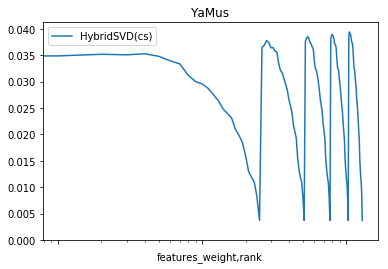

In [34]:
report_results('rank', scores_cold);

In [35]:
config_cold

{'YaMus': {'HybridSVD(cs)': {'features_weight': 0.9, 'rank': 2500}}}

### saving data

In [36]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [37]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 1/1 [13:07:28<13:07:28, 47248.16s/it]

    YaMus folds [█████████████████████████████████████████████] 5/5 [13:07:28<02:20:41, 9449.63s/it]

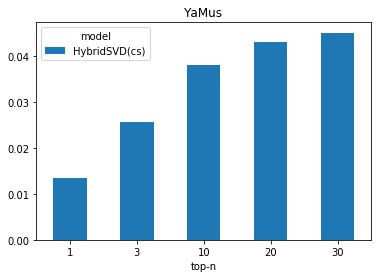

In [38]:
report_results('topn', result_cold, target_metric);

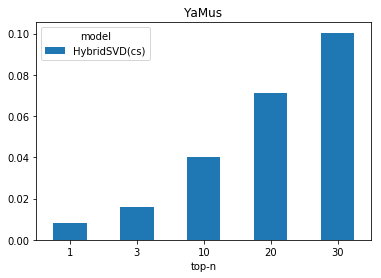

In [39]:
report_results('topn', result_cold, 'coverage');

### saving data

In [40]:
save_results(experiment_name+'_coldstart', cv=result_cold)